In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import scipy;
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import pandas;
import os;
import tensorflow as tf
import math
import time
from sklearn.externals import joblib
%matplotlib inline

In [2]:
print (os.getcwd())
images = os.listdir("Face/vid");

#This below code dynamically calculates the size of total data set.
train_size = len(images)+len(os.listdir("Face/vidFalse"))
#Face/vid contains true values and #Face/vidFalse contains false values.


count = 0
pixel = 100; #change the pixel size if the data set changes

#Depending on the size, X(Features) and Y(Labels) get initialized to zero.
train_data_X = np.zeros((train_size,pixel,pixel),dtype=float)
train_data_Y = np.zeros((train_size,2),dtype=float)

#It loads the true values and puts it in the train_data_X and sets train_data_y=1 ;
for i in images:
    img = np.array(plt.imread('Face/vid/'+i),dtype=float);
    train_data_X[count]=(img-img.min())/(img.max()-img.min());#normalizes the data
    train_data_Y[count]=[0,1];
    count = count+1
    
images = os.listdir("Face/vidFalse");

#It loads the false values and puts it in the train_data_X and sets train_data_y=0;
for i in images:
    img = np.array(plt.imread('Face/vidFalse/'+i),dtype=float);
    train_data_X[count]=(img-img.min())/(img.max()-img.min());
    train_data_Y[count]=[1,0];
    count = count+1
    
print (train_data_X.shape)
print (train_data_Y.shape)

C:\Users\ramki\Documents\Projects\FaceConvolution-master
(563, 100, 100)
(563, 2)


In [3]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_data_X,train_data_Y)

(563, 100, 100)
[ 0.  1.]


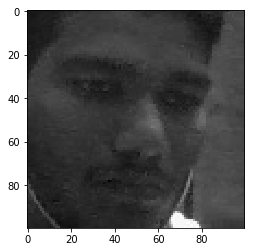

[ 0.  1.]


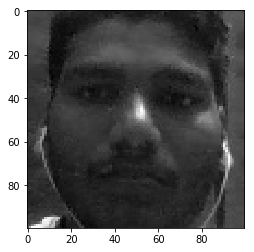

[ 0.  1.]


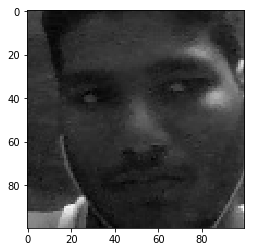

[ 1.  0.]


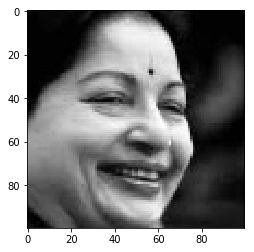

[ 0.  1.]


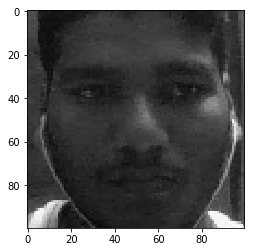

[ 0.  1.]


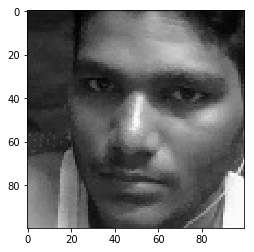

[ 0.  1.]


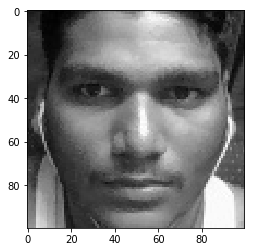

[ 1.  0.]


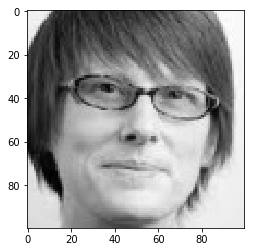

[ 0.  1.]


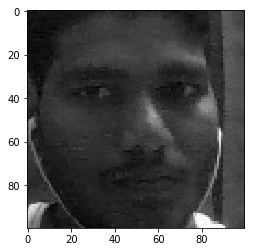

[ 1.  0.]


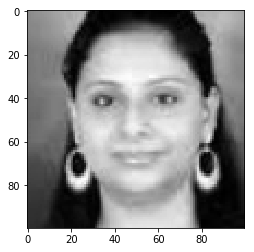

In [4]:
print (train_dataset.shape)
for i in range(0,len(train_dataset[:10])):
    print(train_labels[i])
    plt.imshow(train_dataset[i],cmap='gray');
    plt.show();

In [5]:
image_size = 100
train_size = 500;
X_train = train_dataset[0:train_size].reshape(train_size,(image_size*image_size)).astype(np.float32);
y_train = train_labels[0:train_size][:].astype(np.float32)
X_test = train_dataset[train_size:].reshape(train_dataset[train_size:].shape[0],(image_size*image_size)).astype(np.float32);
y_test = train_labels[train_size:][:].astype(np.float32)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(500, 10000)
(500, 2)
(63, 10000)
(63, 2)


## Hyper Parameters for CNN

In [6]:
image_size = 100
image_size_flat = image_size * image_size
image_shape = (image_size, image_size)
num_channels=1
num_labels = 2
num_iterations = 1000
batch_size = 100
alpha = 0.01;
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
conv_stride1=[1,1,1,1]
# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 4 x 4 pixels.
num_filters2 = 32         # There are 32 of these filters.
conv_stride2=[1,1,1,1]
# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 3 x 3 pixels.
num_filters3 = 48         # There are 48 of these filters.
conv_stride3=[1,2,2,1]
# Fully-connected layer.
fc_size = 160             # Number of neurons in fully-connected layer.

In [7]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(name,input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   list_strides,
                   use_pooling=True     # Use 2x2 max-pooling.
                   ): 

    with tf.name_scope(name):
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        # Create new weights aka. filters with the given shape.
        with tf.name_scope('ConvWeights'):
            weights = new_weights(shape=shape)
            variable_summaries(weights)
        # Create new biases, one for each filter.
        with tf.name_scope('ConvBiases'):
            biases = new_biases(length=num_filters)
            variable_summaries(weights)
        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        layer = tf.nn.conv2d(input=input,
                             filter=weights,
                             strides=list_strides,
                             padding='SAME',
                             use_cudnn_on_gpu=True)
        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases
        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    
    return layer, weights
 

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
def new_fc_layer(name,input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    with tf.name_scope(name):
        # Create new weights and biases.
        with tf.name_scope('Weights'):
            weights = new_weights(shape=[num_inputs, num_outputs])
            variable_summaries(weights)
        with tf.name_scope('Biases'):
            biases = new_biases(length=num_outputs)
            variable_summaries(biases)
        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        # Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)

    return layer

In [8]:
x = tf.placeholder(tf.float32, shape=[None, image_size_flat], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_labels], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
#Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer('ConvLayer1',input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   list_strides=conv_stride1,
                   use_pooling=True
                   )


In [9]:
layer_conv1

<tf.Tensor 'ConvLayer1/Relu:0' shape=(?, 50, 50, 16) dtype=float32>

In [10]:
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer('ConvLayer2',input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   list_strides=conv_stride2,
                   use_pooling=True
                   )

In [11]:
layer_conv2

<tf.Tensor 'ConvLayer2/Relu:0' shape=(?, 25, 25, 32) dtype=float32>

In [12]:
#Convolutional Layer 3
layer_conv3, weights_conv3 = \
    new_conv_layer('ConvLayer3',input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   list_strides=conv_stride3,
                   use_pooling=True
                   )

In [13]:
layer_conv3

<tf.Tensor 'ConvLayer3/Relu:0' shape=(?, 7, 7, 48) dtype=float32>

In [14]:
#Flattening the Output of the Convolutional Layer 3
layer_flat, num_features = flatten_layer(layer_conv3)

In [15]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2352) dtype=float32>

In [16]:
num_features

2352

In [17]:
layer_fc1 = new_fc_layer(name='FCLayer1',input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [18]:
layer_fc1

<tf.Tensor 'FCLayer1/Relu:0' shape=(?, 160) dtype=float32>

In [19]:
layer_fc2 = new_fc_layer(name='OutputLayer',input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_labels,
                         use_relu=False)

In [20]:
layer_fc2

<tf.Tensor 'OutputLayer/add:0' shape=(?, 2) dtype=float32>

In [21]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
tf.summary.scalar('loss', cost)
optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy',accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

# Plotting the Convolutional Weights

In [22]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Plotting the outputs of Convolutional Layer

In [23]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    return fig;

In [24]:
 def plot_image(image):
        plt.imshow(image.reshape(image_shape),interpolation='nearest',cmap='gray')
plt.show()

In [25]:
session=tf.Session()
session.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("/tmp/tensorflow/Face_Logs",session.graph)
summary=tf.summary.merge_all();
saver = tf.train.Saver();
save_dir = 'FaceModels/'
save_path = os.path.join(save_dir, 'model')
#saver.restore(sess=session, save_path=save_path)
offset=0
print("Initialized")
for step in range(num_iterations):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {x : batch_data, y_true : batch_labels}        
        _, l, acc,s = session.run([optimizer, cost, accuracy,summary],feed_dict=feed_dict)
        if (step % 20 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("mini batch accuracy: ", acc)            
            writer.add_summary(s,step)
            writer.flush()
writer.add_summary(s,step)
writer.flush()
saver.save(sess=session, save_path=save_path)
print("Model saved in file: %s" % save_path)
print("done")


Initialized
Minibatch loss at step 0: 0.708092
mini batch accuracy:  0.23
Minibatch loss at step 20: 0.542026
mini batch accuracy:  0.77
Minibatch loss at step 40: 0.125273
mini batch accuracy:  0.96
Minibatch loss at step 60: 0.012053
mini batch accuracy:  1.0
Minibatch loss at step 80: 0.000546
mini batch accuracy:  1.0
Minibatch loss at step 100: 0.000072
mini batch accuracy:  1.0
Minibatch loss at step 120: 0.000042
mini batch accuracy:  1.0
Minibatch loss at step 140: 0.000031
mini batch accuracy:  1.0
Minibatch loss at step 160: 0.000024
mini batch accuracy:  1.0
Minibatch loss at step 180: 0.000020
mini batch accuracy:  1.0
Minibatch loss at step 200: 0.000016
mini batch accuracy:  1.0
Minibatch loss at step 220: 0.000014
mini batch accuracy:  1.0
Minibatch loss at step 240: 0.000012
mini batch accuracy:  1.0
Minibatch loss at step 260: 0.000010
mini batch accuracy:  1.0
Minibatch loss at step 280: 0.000009
mini batch accuracy:  1.0
Minibatch loss at step 300: 0.000008
mini batc

# Filters of Convolutional Layer 1(red is closer to maximum, blue is closer to minimum)

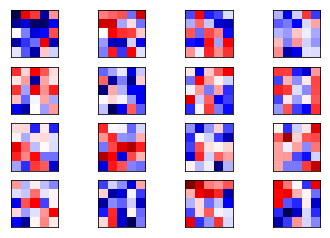

In [26]:
plot_conv_weights(weights=weights_conv1)

# Filters of Convolutional Layer 2

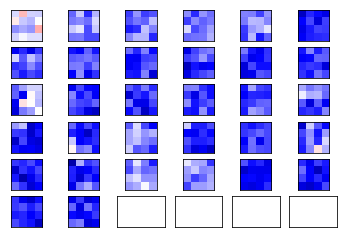

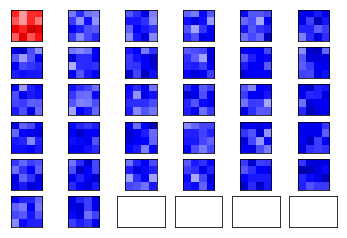

In [27]:
plot_conv_weights(weights=weights_conv2,input_channel=0)
plot_conv_weights(weights=weights_conv2,input_channel=1)

# Filters of Convolutional Layer 3

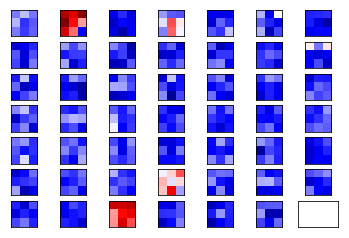

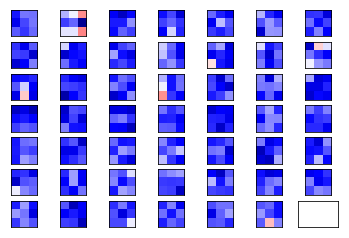

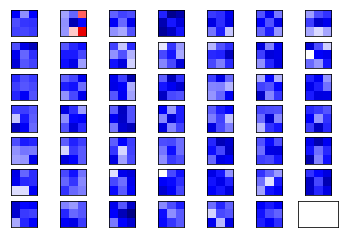

In [28]:
plot_conv_weights(weights=weights_conv3,input_channel=0)
plot_conv_weights(weights=weights_conv3,input_channel=1)
plot_conv_weights(weights=weights_conv3,input_channel=2)

[ 0.  1.]


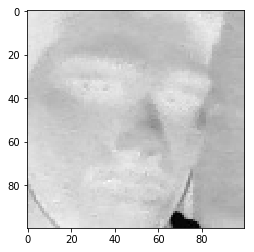

[ 0.  1.]


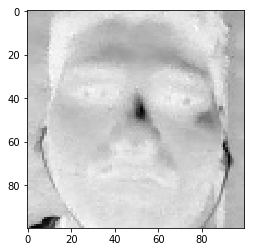

[ 0.  1.]


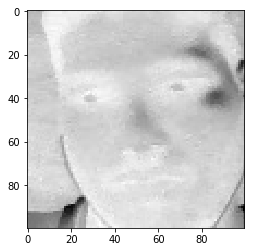

[ 1.  0.]


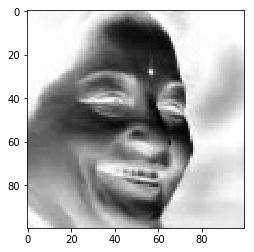

[ 0.  1.]


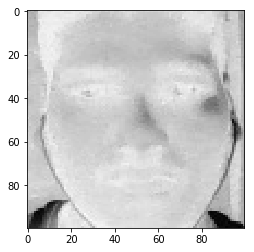

[ 0.  1.]


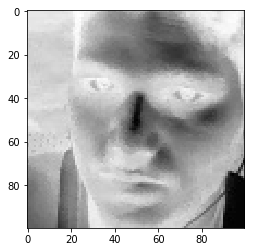

[ 0.  1.]


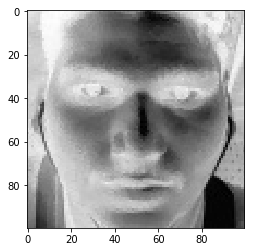

[ 1.  0.]


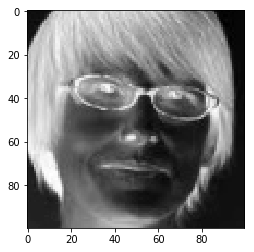

[ 0.  1.]


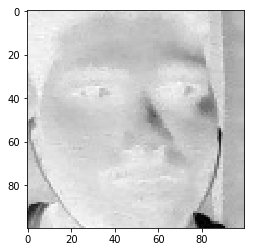

[ 1.  0.]


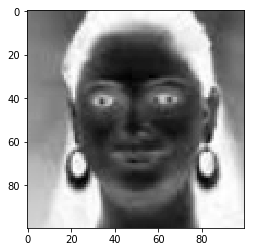

In [29]:
for i in range(0,len(train_dataset[:10])):
    print(train_labels[i])
    plt.imshow(train_dataset[i],cmap='binary');
    plt.show();

In [30]:
#Puts the Convolution Plots into a directory
def print_convImage(layer,image,name):
    directory = 'Convolution/Images/'+str(layer.name.split('/')[0])
    if not os.path.exists(directory):#if directory is not available, creates a new directory.
        os.makedirs(directory)
    fig = plot_conv_layer(layer=layer,image=image)
    fig.savefig(directory+'/'+str(name)+'.png');
    

Image 0


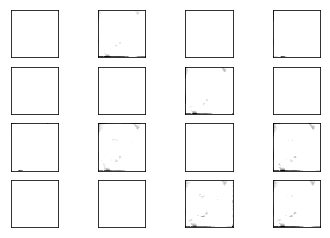

Image 1


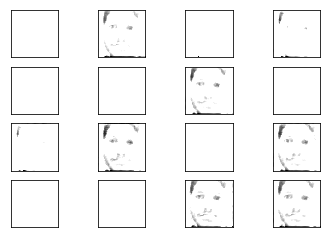

Image 2


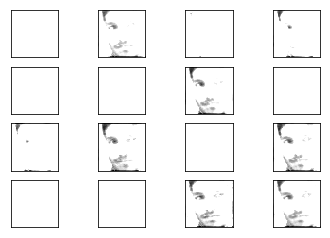

Image 3


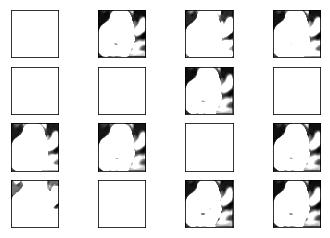

Image 4


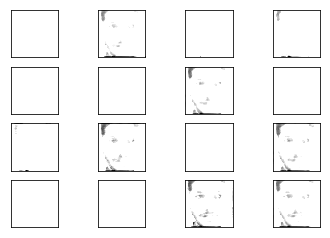

Image 5


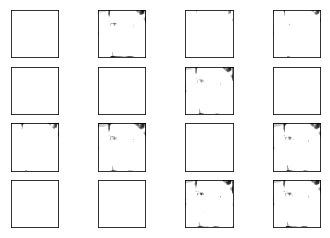

Image 6


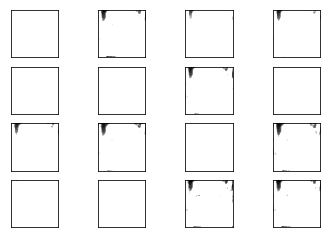

Image 7


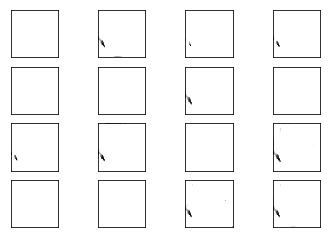

Image 8


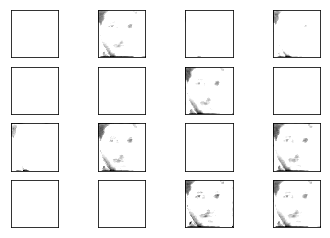

Image 9


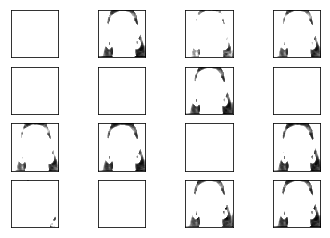

In [31]:

for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv1,image=X_train[i],name=i)

Image 0


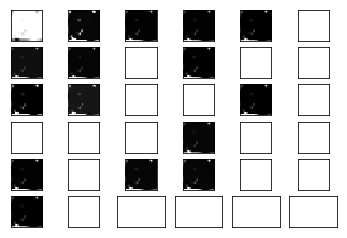

Image 1


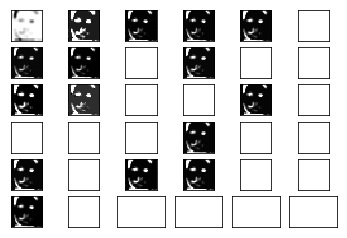

Image 2


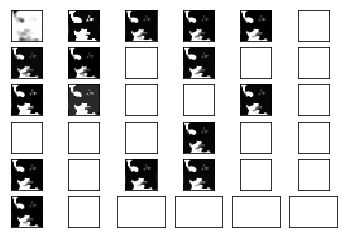

Image 3


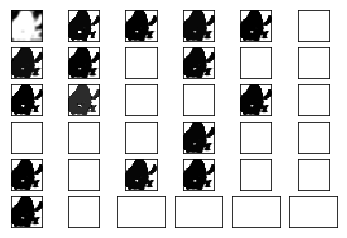

Image 4


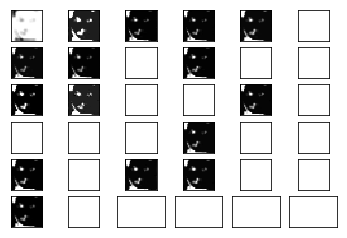

Image 5


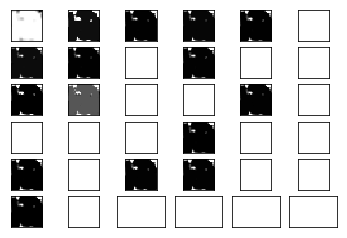

Image 6


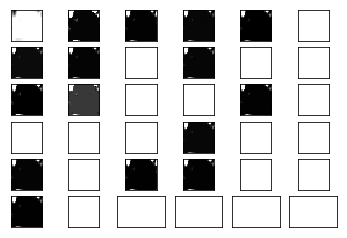

Image 7


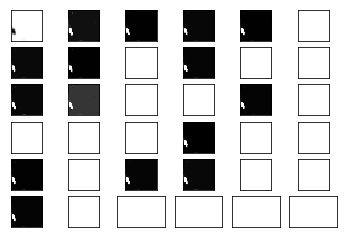

Image 8


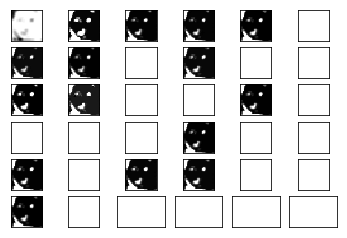

Image 9


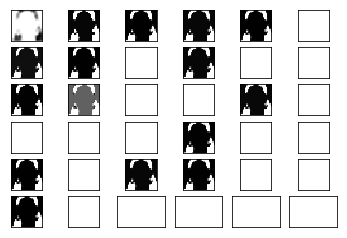

In [32]:
for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv2,image=X_train[i],name=i)

Image 0


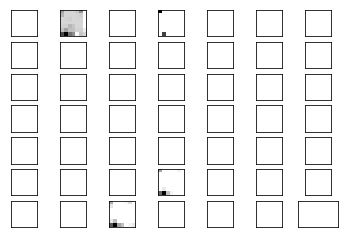

Image 1


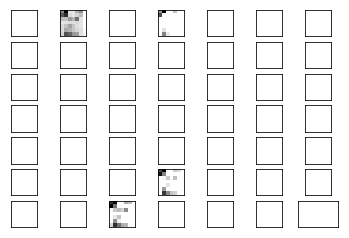

Image 2


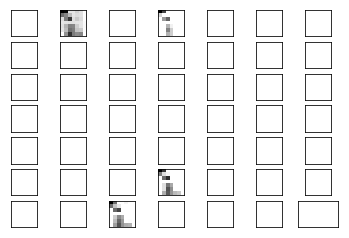

Image 3


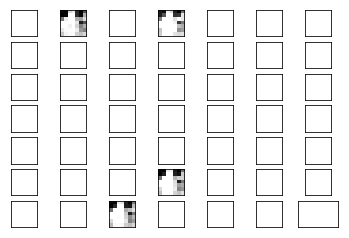

Image 4


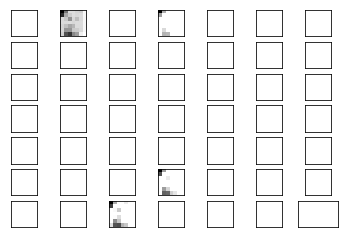

Image 5


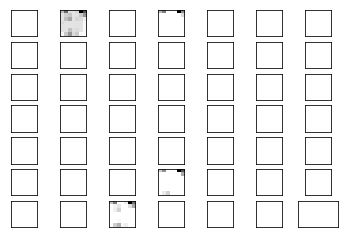

Image 6


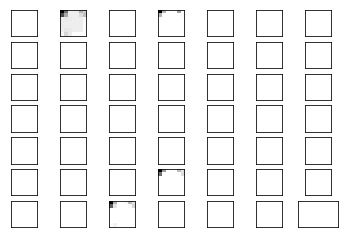

Image 7


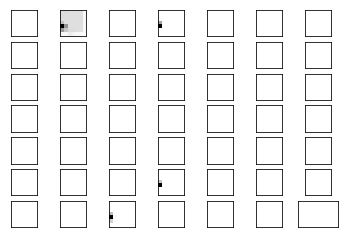

Image 8


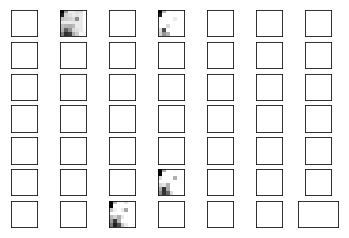

Image 9


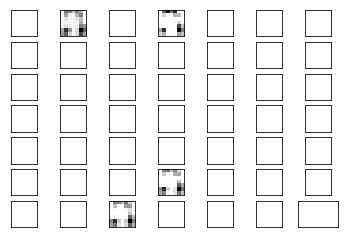

In [33]:
for i in range(10):
    print('Image',i)
    print_convImage(layer=layer_conv3,image=X_train[i],name=i)

In [34]:
print(tf.__version__)

0.12.1
